In [1]:
import requests
import pandas

### Download TLC Trip Record Data from https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page
#### We will download and analyze data of last 6 months of 2020 for green taxi

In [2]:
all_years = [2020]
all_months = ['09', '10', '11', '12']

In [3]:
tripdata_prefix = 'https://nyc-tlc.s3.amazonaws.com/trip+data/'
yellow_tripdata = 'yellow_tripdata_%d-%s.csv'

In [4]:
for year in all_years:
  for month in all_months:
    yellow_csv = yellow_tripdata % (year, month)
    response = requests.get( tripdata_prefix + yellow_csv, allow_redirects=True)
    open( yellow_csv, 'wb').write(response.content)

### Let us merge all this data together now! 

In [5]:
all_yellow_trip_data = pandas.DataFrame()

for year in all_years:
  for month in all_months:
    yellow_csv = pandas.read_csv( yellow_tripdata % (year, month) )
    all_yellow_trip_data = all_yellow_trip_data.append(yellow_csv)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
all_yellow_trip_data.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
count,5.598426e+06,5.598426e+06,5.993025e+06,5.598426e+06,5.993025e+06,5.993025e+06,5.598426e+06,5.993025e+06,5.993025e+06,5.993025e+06,5.993025e+06,5.993025e+06,5.993025e+06,5.993025e+06,5.993025e+06
mean,1.682752e+00,1.420352e+00,4.468573e+00,1.028994e+00,1.654612e+02,1.615342e+02,1.283227e+00,1.229730e+01,9.414743e-01,4.933245e-01,1.963303e+00,2.193829e-01,2.970282e-01,1.769699e+01,2.155705e+00
std,4.654048e-01,1.059677e+00,5.536670e+02,5.732212e-01,6.803212e+01,7.196750e+01,4.909419e-01,4.435501e+02,1.203048e+00,7.603060e-02,2.351412e+00,1.318930e+00,4.156468e-02,4.435970e+02,8.894939e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-5.000000e+02,-2.650000e+01,-5.000000e-01,-1.030600e+02,-2.962000e+01,-3.000000e-01,-5.028000e+02,-2.500000e+00
25%,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.140000e+02,1.070000e+02,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,1.115000e+01,2.500000e+00
50%,2.000000e+00,1.000000e+00,1.700000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,9.000000e+00,5.000000e-01,5.000000e-01,1.960000e+00,0.000000e+00,3.000000e-01,1.416000e+01,2.500000e+00
75%,2.000000e+00,1.000000e+00,2.970000e+00,1.000000e+00,2.360000e+02,2.360000e+02,2.000000e+00,1.350000e+01,2.500000e+00,5.000000e-01,2.750000e+00,0.000000e+00,3.000000e-01,1.956000e+01,2.500000e+00
max,2.000000e+00,9.000000e+00,3.509149e+05,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,9.983100e+05,3.609000e+01,3.080000e+01,1.393560e+03,6.000000e+02,3.000000e-01,9.983256e+05,3.000000e+00


In [7]:
print('Shape of Yellow Taxi trip data : ', all_yellow_trip_data.shape)

Shape of Yellow Taxi trip data :  (5993025, 18)


# Data types for the different columns

In [8]:
all_yellow_trip_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5993025 entries, 0 to 1461896
Data columns (total 18 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               float64
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        float64
 4   trip_distance          float64
 5   RatecodeID             float64
 6   store_and_fwd_flag     object 
 7   PULocationID           int64  
 8   DOLocationID           int64  
 9   payment_type           float64
 10  fare_amount            float64
 11  extra                  float64
 12  mta_tax                float64
 13  tip_amount             float64
 14  tolls_amount           float64
 15  improvement_surcharge  float64
 16  total_amount           float64
 17  congestion_surcharge   float64
dtypes: float64(13), int64(2), object(3)
memory usage: 868.7+ MB


### 1. Data Imputation


In [9]:
# What is the percentage of missing data for different columns ?
(all_yellow_trip_data.isna().sum(axis=0)*100.0)/all_yellow_trip_data.shape[0]

VendorID                 6.584304
tpep_pickup_datetime     0.000000
tpep_dropoff_datetime    0.000000
passenger_count          6.584304
trip_distance            0.000000
RatecodeID               6.584304
store_and_fwd_flag       6.584304
PULocationID             0.000000
DOLocationID             0.000000
payment_type             6.584304
fare_amount              0.000000
extra                    0.000000
mta_tax                  0.000000
tip_amount               0.000000
tolls_amount             0.000000
improvement_surcharge    0.000000
total_amount             0.000000
congestion_surcharge     0.000000
dtype: float64

#### We see that for VendorID, passenger_count, RatecodeID, store_and_fwd_flag and payment_type, the input data is missing for about 6.7% of total data. How do we proceed? 
#### Given the percentage of missing data is low, we will drop the rows with missing data!

In [10]:
all_data_no_na = all_yellow_trip_data.dropna()
assert( sum(all_data_no_na.isna().sum()) == 0 )

all_data_no_na.shape

(5598426, 18)

### 2. Data Preprocessing 

In [11]:
# Let's look at the unique values for different columns
for column in all_data_no_na.columns:
  series = all_data_no_na[column]
  print('Column : ', column , ' min : ', series.min(), ' max : ', series.max())

Column :  VendorID  min :  1.0  max :  2.0
Column :  tpep_pickup_datetime  min :  2002-12-31 23:06:55  max :  2021-06-10 10:10:48
Column :  tpep_dropoff_datetime  min :  2002-12-31 23:08:03  max :  2021-06-10 10:41:42
Column :  passenger_count  min :  0.0  max :  9.0
Column :  trip_distance  min :  0.0  max :  167329.45
Column :  RatecodeID  min :  1.0  max :  99.0
Column :  store_and_fwd_flag  min :  N  max :  Y
Column :  PULocationID  min :  1  max :  265
Column :  DOLocationID  min :  1  max :  265
Column :  payment_type  min :  1.0  max :  5.0
Column :  fare_amount  min :  -500.0  max :  998310.03
Column :  extra  min :  -26.5  max :  36.09
Column :  mta_tax  min :  -0.5  max :  30.8
Column :  tip_amount  min :  -103.06  max :  1393.56
Column :  tolls_amount  min :  -29.62  max :  600.0
Column :  improvement_surcharge  min :  -0.3  max :  0.3
Column :  total_amount  min :  -502.8  max :  998325.61
Column :  congestion_surcharge  min :  -2.5  max :  3.0


# Creating new features

## Date time stamps

In [12]:
all_data_no_na['drop_timestamp'] = pandas.to_datetime(all_data_no_na['tpep_dropoff_datetime'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
all_data_no_na['pickup_timestamp'] = pandas.to_datetime(all_data_no_na['tpep_pickup_datetime'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [14]:
all_data_no_na['month'] = all_data_no_na['pickup_timestamp'].dt.month
all_data_no_na['day'] = all_data_no_na['pickup_timestamp'].dt.day
all_data_no_na['week'] = all_data_no_na['pickup_timestamp'].dt.week

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  This is separate from the ipykernel package so we 

In [15]:
all_data_no_na['weekday'] = all_data_no_na['pickup_timestamp'].dt.weekday

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
all_data_no_na['starting_hour'] = all_data_no_na['pickup_timestamp'].dt.hour
all_data_no_na['ending_hour'] = all_data_no_na['drop_timestamp'].dt.hour


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
all_data_no_na['trip_time'] = all_data_no_na['drop_timestamp'] -all_data_no_na['pickup_timestamp']
all_data_no_na['trip_time'] = all_data_no_na['trip_time'].dt.total_seconds()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
import numpy

In [19]:
all_data_no_na['working_hours'] = all_data_no_na['starting_hour'].isin(numpy.arange(8,21,1)).astype("int")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
all_data_no_na

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,drop_timestamp,pickup_timestamp,month,day,week,weekday,starting_hour,ending_hour,trip_time,working_hours
0,2.0,2020-09-01 00:38:58,2020-09-01 01:08:12,1.0,10.76,1.0,N,132,62,1.0,32.5,0.5,0.5,4.40,0.0,0.3,38.20,0.0,2020-09-01 01:08:12,2020-09-01 00:38:58,9,1,36,1,0,1,1754.0,0
1,2.0,2020-09-01 00:55:26,2020-09-01 01:15:34,1.0,6.37,1.0,N,48,129,1.0,20.5,0.5,0.5,3.00,0.0,0.3,27.30,2.5,2020-09-01 01:15:34,2020-09-01 00:55:26,9,1,36,1,0,1,1208.0,0
2,2.0,2020-09-01 00:00:40,2020-09-01 00:10:25,5.0,2.32,1.0,N,102,37,1.0,9.5,0.5,0.5,4.00,0.0,0.3,14.80,0.0,2020-09-01 00:10:25,2020-09-01 00:00:40,9,1,36,1,0,0,585.0,0
3,2.0,2020-09-01 00:26:01,2020-09-01 00:35:50,1.0,1.82,1.0,Y,137,246,1.0,8.5,0.5,0.5,3.08,0.0,0.3,15.38,2.5,2020-09-01 00:35:50,2020-09-01 00:26:01,9,1,36,1,0,0,589.0,0
4,1.0,2020-09-01 00:29:09,2020-09-01 01:00:33,1.0,4.90,1.0,N,79,170,1.0,24.0,3.0,0.5,1.00,0.0,0.3,28.80,2.5,2020-09-01 01:00:33,2020-09-01 00:29:09,9,1,36,1,0,1,1884.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1362436,2.0,2020-12-31 23:05:33,2020-12-31 23:31:36,1.0,11.30,1.0,N,107,242,2.0,33.0,0.5,0.5,0.00,0.0,0.3,36.80,2.5,2020-12-31 23:31:36,2020-12-31 23:05:33,12,31,53,3,23,23,1563.0,0
1362437,2.0,2020-12-31 22:57:20,2020-12-31 23:05:33,1.0,2.18,1.0,N,236,161,1.0,9.0,0.5,0.5,2.56,0.0,0.3,15.36,2.5,2020-12-31 23:05:33,2020-12-31 22:57:20,12,31,53,3,22,23,493.0,0
1362438,2.0,2020-12-31 23:40:35,2020-12-31 23:48:43,1.0,2.52,1.0,N,236,24,1.0,9.5,0.5,0.5,4.00,0.0,0.3,17.30,2.5,2020-12-31 23:48:43,2020-12-31 23:40:35,12,31,53,3,23,23,488.0,0
1362439,2.0,2020-12-31 23:54:57,2020-12-31 23:57:39,1.0,0.59,1.0,N,238,239,1.0,4.5,0.5,0.5,2.08,0.0,0.3,10.38,2.5,2020-12-31 23:57:39,2020-12-31 23:54:57,12,31,53,3,23,23,162.0,0


# Outliers

In [21]:
all_data_no_na.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,month,day,week,weekday,starting_hour,ending_hour,trip_time,working_hours
count,5.598426e+06,5.598426e+06,5.598426e+06,5.598426e+06,5.598426e+06,5.598426e+06,5.598426e+06,5.598426e+06,5.598426e+06,5.598426e+06,5.598426e+06,5.598426e+06,5.598426e+06,5.598426e+06,5.598426e+06,5.598426e+06,5.598426e+06,5.598426e+06,5.598426e+06,5.598426e+06,5.598426e+06,5.598426e+06,5.598426e+06
mean,1.682752e+00,1.420352e+00,2.533477e+00,1.028994e+00,1.663312e+02,1.633632e+02,1.283227e+00,1.131166e+01,1.004982e+00,4.930735e-01,1.929994e+00,1.524950e-01,2.968224e-01,1.673942e+01,2.269684e+00,1.051508e+01,1.565311e+01,4.439497e+01,2.835702e+00,1.402618e+01,1.413749e+01,8.754425e+02,8.311802e-01
std,4.654048e-01,1.059677e+00,8.263963e+01,5.732212e-01,6.687795e+01,7.131872e+01,4.909419e-01,4.588832e+02,1.218750e+00,7.794472e-02,2.394524e+00,1.124219e+00,4.298418e-02,4.589301e+02,7.584160e-01,1.088119e+00,8.735122e+00,4.817208e+00,1.885082e+00,4.813332e+00,4.865541e+00,3.813654e+03,3.745927e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-5.000000e+02,-2.650000e+01,-5.000000e-01,-1.030600e+02,-2.962000e+01,-3.000000e-01,-5.028000e+02,-2.500000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.125670e+05,0.000000e+00
25%,1.000000e+00,1.000000e+00,9.900000e-01,1.000000e+00,1.250000e+02,1.070000e+02,1.000000e+00,6.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,1.080000e+01,2.500000e+00,1.000000e+01,8.000000e+00,4.000000e+01,1.000000e+00,1.100000e+01,1.100000e+01,3.540000e+02,1.000000e+00
50%,2.000000e+00,1.000000e+00,1.600000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,8.500000e+00,5.000000e-01,5.000000e-01,1.860000e+00,0.000000e+00,3.000000e-01,1.380000e+01,2.500000e+00,1.000000e+01,1.600000e+01,4.400000e+01,3.000000e+00,1.400000e+01,1.400000e+01,5.720000e+02,1.000000e+00
75%,2.000000e+00,1.000000e+00,2.740000e+00,1.000000e+00,2.360000e+02,2.360000e+02,2.000000e+00,1.250000e+01,2.500000e+00,5.000000e-01,2.750000e+00,0.000000e+00,3.000000e-01,1.836000e+01,2.500000e+00,1.100000e+01,2.300000e+01,4.900000e+01,4.000000e+00,1.800000e+01,1.800000e+01,9.020000e+02,1.000000e+00
max,2.000000e+00,9.000000e+00,1.673295e+05,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,9.983100e+05,3.609000e+01,3.080000e+01,1.393560e+03,6.000000e+02,3.000000e-01,9.983256e+05,3.000000e+00,1.200000e+01,3.100000e+01,5.300000e+01,6.000000e+00,2.300000e+01,2.300000e+01,3.112360e+05,1.000000e+00


Following columns aeem to have outliers in them - 
- Trip distance
- fare_amount
- total_amount
- trip_time


(as there max amount is much higher than their 75 quantile values)

To confirm this, lets look into quantile values for the data.

In [22]:
all_data_no_na.quantile([0.01,0.05 ,0.10 , 0.25,0.50,0.75,0.90,0.95 , 0.99])

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,month,day,week,weekday,starting_hour,ending_hour,trip_time,working_hours
0.01,1.0,0.0,0.00,1.0,24.0,13.0,1.0,2.5,0.0,0.5,0.00,0.00,0.3,4.80,0.0,9.0,1.0,36.0,0.0,0.0,0.0,57.0,0.0
0.05,1.0,1.0,0.46,1.0,48.0,43.0,1.0,4.0,0.0,0.5,0.00,0.00,0.3,7.80,0.0,9.0,2.0,37.0,0.0,6.0,6.0,166.0,0.0
0.10,1.0,1.0,0.61,1.0,68.0,50.0,1.0,5.0,0.0,0.5,0.00,0.00,0.3,8.80,2.5,9.0,3.0,38.0,0.0,8.0,8.0,225.0,0.0
0.25,1.0,1.0,0.99,1.0,125.0,107.0,1.0,6.0,0.0,0.5,0.00,0.00,0.3,10.80,2.5,10.0,8.0,40.0,1.0,11.0,11.0,354.0,1.0
0.50,2.0,1.0,1.60,1.0,162.0,162.0,1.0,8.5,0.5,0.5,1.86,0.00,0.3,13.80,2.5,10.0,16.0,44.0,3.0,14.0,14.0,572.0,1.0
0.75,2.0,1.0,2.74,1.0,236.0,236.0,2.0,12.5,2.5,0.5,2.75,0.00,0.3,18.36,2.5,11.0,23.0,49.0,4.0,18.0,18.0,902.0,1.0
0.90,2.0,2.0,4.90,1.0,239.0,243.0,2.0,19.5,3.0,0.5,3.96,0.00,0.3,26.00,2.5,12.0,28.0,51.0,5.0,20.0,20.0,1337.0,1.0
0.95,2.0,4.0,7.60,1.0,262.0,262.0,2.0,27.0,3.5,0.5,5.00,0.00,0.3,34.56,2.5,12.0,30.0,52.0,6.0,22.0,22.0,1707.0,1.0
0.99,2.0,6.0,17.41,2.0,263.0,263.0,3.0,52.0,3.5,0.5,10.00,6.12,0.3,64.80,2.5,12.0,31.0,53.0,6.0,23.0,23.0,2856.0,1.0


As we can see, even the 99th quantiles is much lower than max values, those values must be outliers.

Since we have a large sample size, we can remove these outliers


In [23]:
outlier_cols =  [ 'trip_distance' , 'fare_amount' , 'total_amount' , 'trip_time' ]

no_outlier_df = all_data_no_na.copy()

for col in outlier_cols:
  print(col)
  no_outlier_df.drop(no_outlier_df[no_outlier_df[col] > no_outlier_df[col].quantile([0.99]).iloc[0]].index , axis = 0 , inplace = True)

trip_distance
fare_amount
total_amount
trip_time


In [24]:
for col in outlier_cols:
  print(col)
  no_outlier_df.drop(no_outlier_df[no_outlier_df[col] < no_outlier_df[col].quantile([0.01]).iloc[0]].index , axis = 0 , inplace = True)

trip_distance
fare_amount
total_amount
trip_time


In [25]:
no_outlier_df[outlier_cols].describe()

,trip_distance,fare_amount,total_amount,trip_time
count,4.399871e+06,4.399871e+06,4.399871e+06,4.399871e+06
mean,2.123975e+00,9.932396e+00,1.521490e+01,6.555261e+02
std,1.767759e+00,5.350731e+00,6.181900e+00,3.922254e+02
min,0.000000e+00,2.500000e+00,5.800000e+00,9.200000e+01
25%,1.000000e+00,6.000000e+00,1.080000e+01,3.590000e+02
50%,1.600000e+00,8.500000e+00,1.356000e+01,5.640000e+02
75%,2.600000e+00,1.200000e+01,1.780000e+01,8.620000e+02
max,1.733000e+01,4.150000e+01,4.342000e+01,2.217000e+03


As we can see that outliers have been removed.

In [26]:
import seaborn as sns

In [27]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

### Visualizing data in 

In [28]:
no_outlier_df.shape

(4399871, 28)

In [29]:
#########
######### Modify this line if you need more
no_outlier_df = no_outlier_df.sample(100000)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


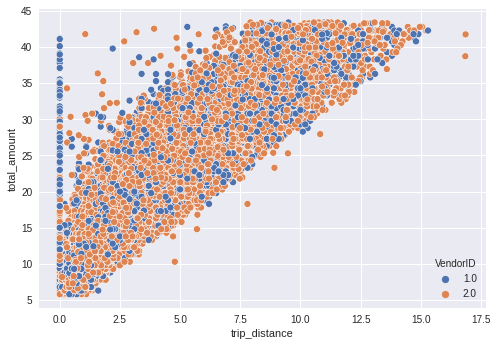

In [30]:
sns.scatterplot(no_outlier_df['trip_distance'] , no_outlier_df['total_amount'] , hue = no_outlier_df['VendorID'] , palette = 'deep')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


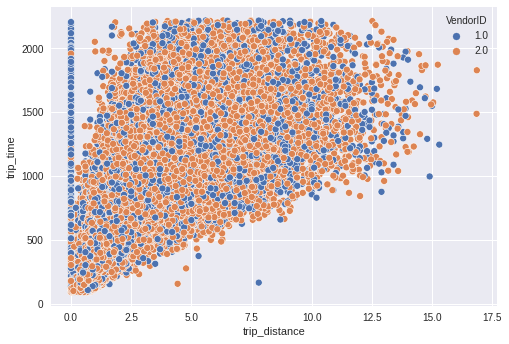

In [31]:
sns.scatterplot(no_outlier_df['trip_distance'] , no_outlier_df['trip_time'], hue = no_outlier_df['VendorID'], palette = 'deep')

Lets look If amount of tip depends on type of payment being used?

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


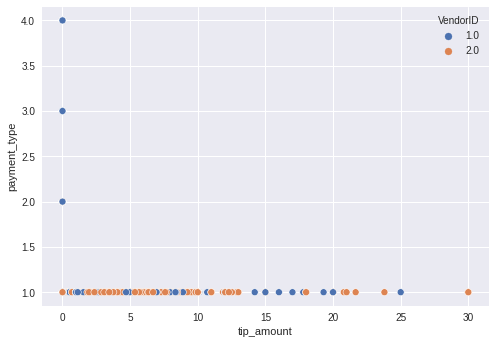

In [32]:
sns.scatterplot(no_outlier_df['tip_amount'] , no_outlier_df['payment_type'], hue = no_outlier_df['VendorID'], palette = 'deep')

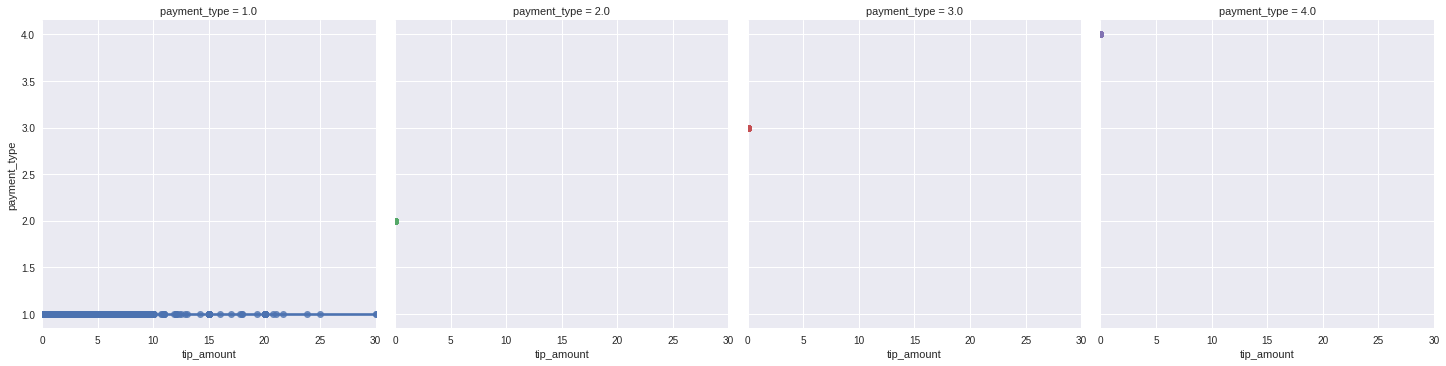

In [33]:
sns.lmplot(x="tip_amount", y='payment_type', col="payment_type", hue="payment_type", data=no_outlier_df)

In [34]:
no_outlier_df.payment_type.nunique

<bound method IndexOpsMixin.nunique of 741295     1.0
836900     1.0
1101429    2.0
570656     1.0
245088     2.0
          ... 
496003     1.0
281714     1.0
746903     1.0
289468     1.0
1374899    2.0
Name: payment_type, Length: 100000, dtype: float64>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

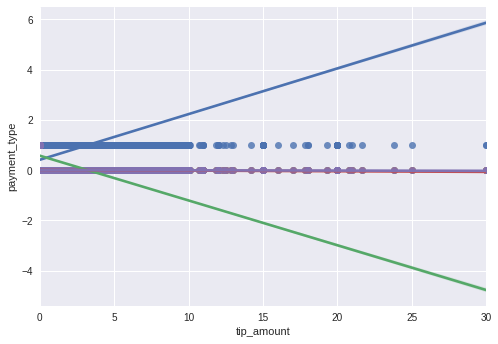

In [35]:
sns.regplot(no_outlier_df['tip_amount'] ,no_outlier_df['payment_type'] == 1)
sns.regplot(no_outlier_df['tip_amount'] ,no_outlier_df['payment_type'] == 2)
sns.regplot(no_outlier_df['tip_amount'] ,no_outlier_df['payment_type'] == 3)
sns.regplot(no_outlier_df['tip_amount'] ,no_outlier_df['payment_type'] == 4)

# Lets try to fit a Linear regression model and see how well does it fit to our data

Linear regression model for order = 1

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


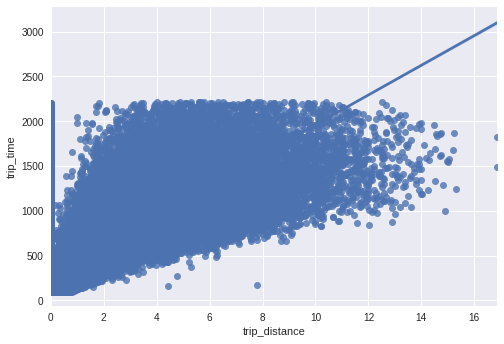

In [36]:
sns.regplot(no_outlier_df['trip_distance'] , no_outlier_df['trip_time'])

As expected, there is seems a linear relation between the trip distance and trip_time.

Polynomial regression for order of 5

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


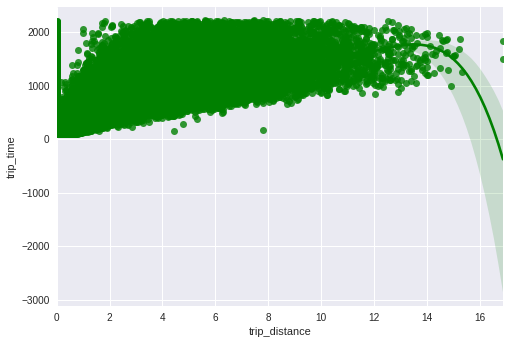

In [37]:
sns.regplot(no_outlier_df['trip_distance'] , no_outlier_df['trip_time'], order = 5 , color = 'g')

# Pearson correlation cofficient

Text(0.5, 1.0, 'Pearson correlation cofficient')

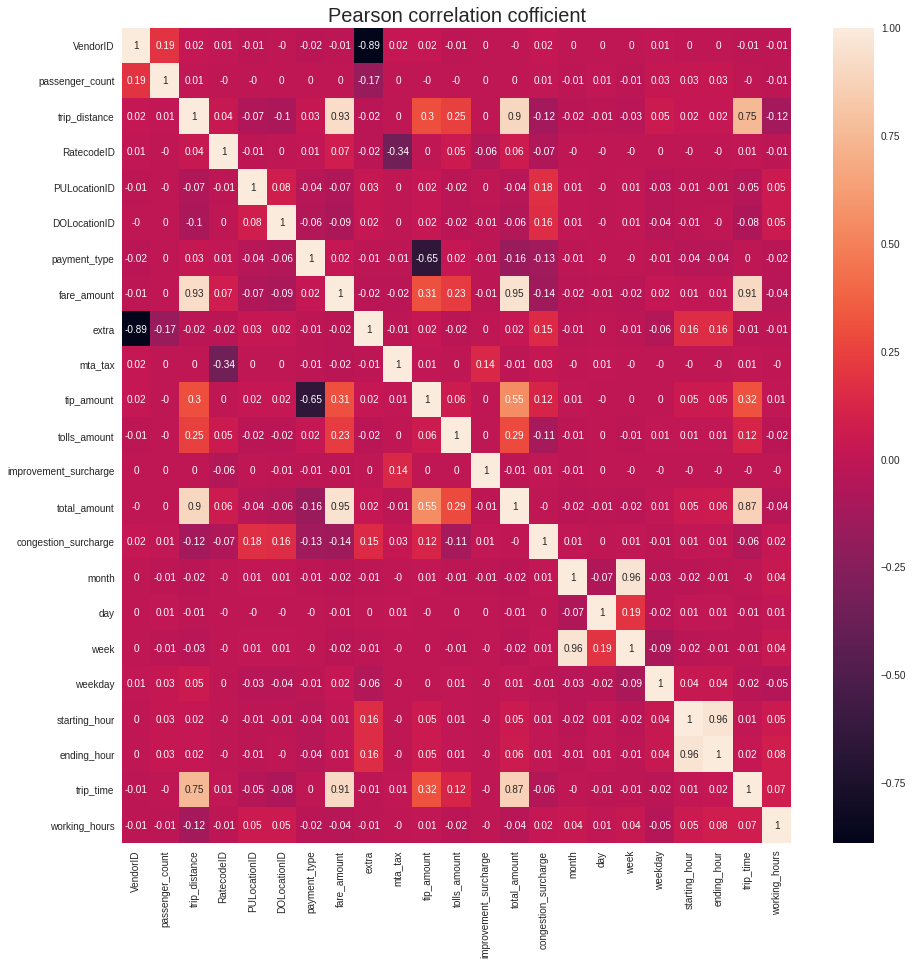

In [38]:
plt.figure(figsize=(15,15))
sns.heatmap(round(no_outlier_df.corr(method = 'pearson') , 2), annot = True)
plt.title('Pearson correlation cofficient' , size = 20)

# Spearman correlation cofficient

Text(0.5, 1.0, 'Spearman correlation cofficient')

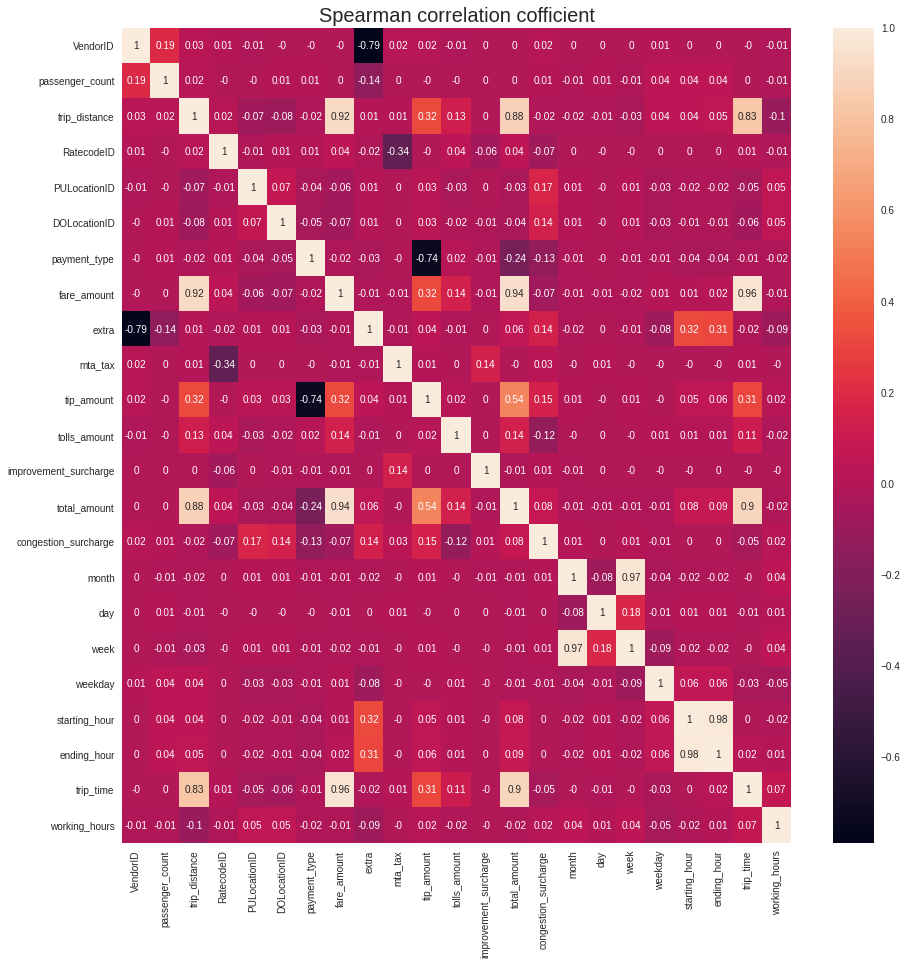

In [39]:
plt.figure(figsize=(15,15))
sns.heatmap(round(no_outlier_df.corr(method = 'spearman') , 2), annot = True)
plt.title('Spearman correlation cofficient' , size = 20)

# Kendall correlation cofficient

Text(0.5, 1.0, 'Kendall correlation cofficient')

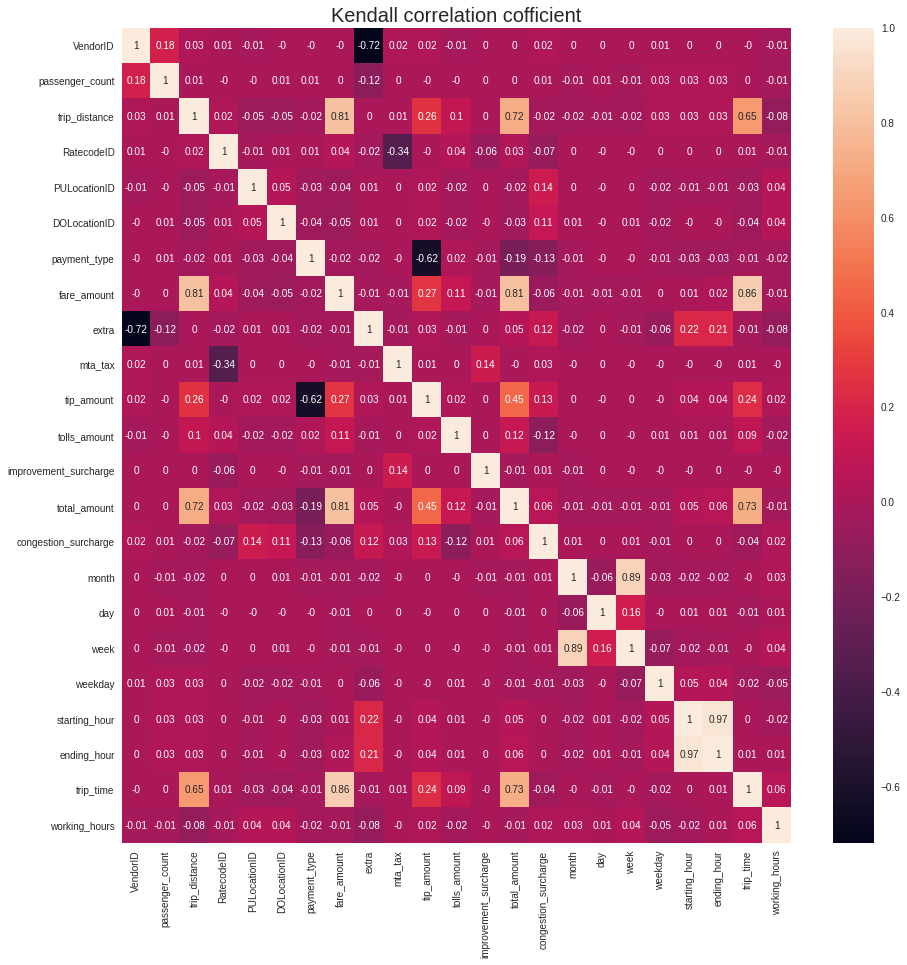

In [40]:
plt.figure(figsize=(15,15))
sns.heatmap(round(no_outlier_df.corr(method = 'kendall') , 2), annot = True)
plt.title('Kendall correlation cofficient' , size = 20)

In [41]:
heatmap_cols = ['fare_amount' , 'tip_amount', 'trip_time' , 'trip_distance' , 'total_amount' , 'starting_hour']



Text(0.5, 1.0, 'Spearman correlation cofficient')

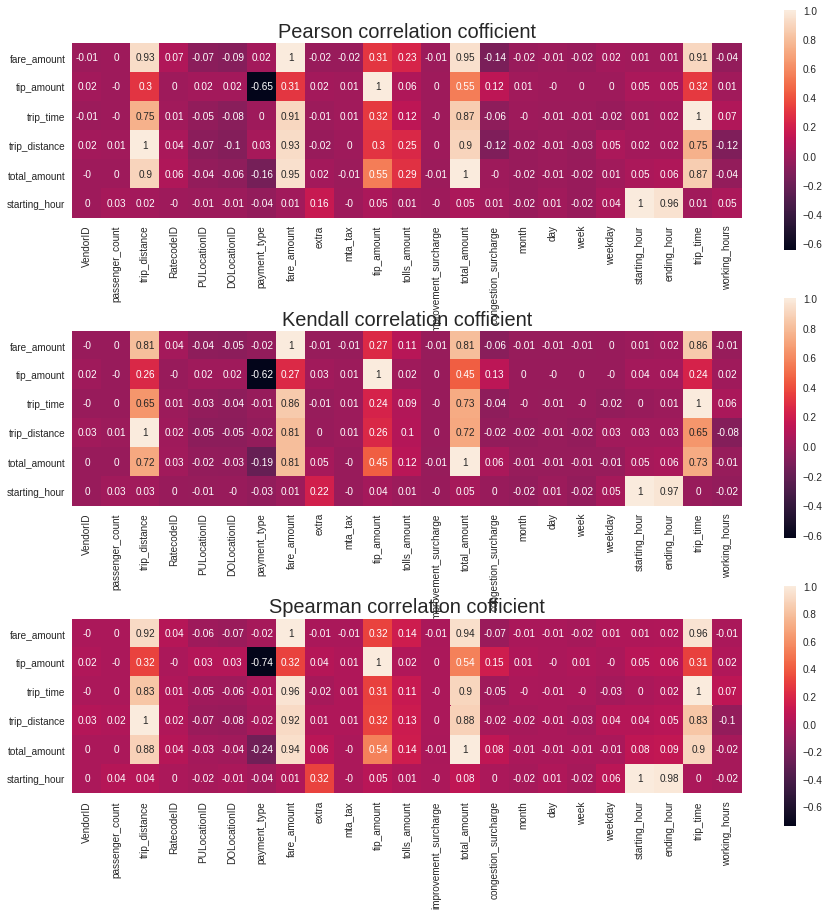

In [42]:

plt.figure(figsize=(15,15))
plt.subplot(3,1,1)
sns.heatmap(round(no_outlier_df.corr(method = 'pearson')[heatmap_cols].transpose(), 2), annot = True , square=True)
plt.title('Pearson correlation cofficient' , size = 20)

plt.subplot(3,1,2)
sns.heatmap(round(no_outlier_df.corr(method = 'kendall')[heatmap_cols].transpose(), 2), annot = True, square = True)
plt.title('Kendall correlation cofficient' , size = 20)

plt.subplot(3,1,3)
sns.heatmap(round(no_outlier_df.corr(method = 'spearman')[heatmap_cols].transpose(), 2), annot = True, square=True)
plt.title('Spearman correlation cofficient' , size = 20)


We seem to be getting similar results from all the correlation tests.

In [43]:
no_outlier_df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'drop_timestamp',
       'pickup_timestamp', 'month', 'day', 'week', 'weekday', 'starting_hour',
       'ending_hour', 'trip_time', 'working_hours'],
      dtype='object')

In [44]:

drop_cols = ['tpep_pickup_datetime' , 'tpep_dropoff_datetime' , 'store_and_fwd_flag','drop_timestamp' , 'pickup_timestamp']
un_scaled_df = no_outlier_df.drop(columns = drop_cols)

# Min-Max Scaling

In [45]:
from sklearn.preprocessing import MinMaxScaler

In [46]:
scaler = MinMaxScaler()

In [47]:
scaled_df = scaler.fit_transform(un_scaled_df)
scaled_df = pandas.DataFrame(scaled_df , columns = un_scaled_df.columns)
scaled_df

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,month,day,week,weekday,starting_hour,ending_hour,trip_time,working_hours
0,0.0,0.166667,0.065243,0.0,0.526718,0.603053,0.000000,0.128205,0.714286,1.0,0.090000,0.0,1.0,0.204678,1.0,0.000000,0.600000,0.117647,0.833333,0.782609,0.782609,0.200471,1.0
1,1.0,0.833333,0.130486,0.0,0.610687,0.889313,0.000000,0.192308,0.285714,1.0,0.071333,0.0,1.0,0.282828,1.0,0.666667,0.533333,0.647059,0.166667,0.782609,0.782609,0.282353,1.0
2,1.0,0.166667,0.156584,0.0,0.538168,0.698473,0.333333,0.217949,0.000000,1.0,0.000000,0.0,1.0,0.225944,1.0,0.000000,0.866667,0.176471,1.000000,0.739130,0.739130,0.311529,1.0
3,0.0,0.166667,0.124555,0.0,0.171756,0.896947,0.000000,0.217949,0.714286,1.0,0.118333,0.0,1.0,0.320308,1.0,0.000000,0.500000,0.117647,0.333333,0.391304,0.434783,0.338824,1.0
4,1.0,0.166667,0.173784,0.0,0.896947,0.248092,0.333333,0.217949,0.000000,1.0,0.000000,0.0,1.0,0.225944,1.0,0.333333,0.166667,0.294118,0.166667,0.434783,0.434783,0.296471,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.0,0.166667,0.260973,0.0,0.698473,0.984733,0.000000,0.307692,0.857143,1.0,0.033333,0.0,1.0,0.358852,1.0,0.333333,0.333333,0.294118,1.000000,0.043478,0.043478,0.350118,0.0
99996,1.0,0.166667,0.071174,0.0,0.274809,0.992366,0.000000,0.128205,0.285714,1.0,0.078667,0.0,1.0,0.222222,1.0,0.666667,0.166667,0.529412,0.666667,0.826087,0.826087,0.200471,1.0
99997,1.0,0.166667,0.172005,0.0,0.896947,0.603053,0.000000,0.294872,0.000000,1.0,0.115333,0.0,1.0,0.397661,1.0,1.000000,0.500000,0.882353,0.333333,0.391304,0.391304,0.474824,1.0
99998,0.0,0.166667,0.083037,0.0,0.526718,0.988550,0.000000,0.141026,0.714286,1.0,0.037667,0.0,1.0,0.176236,1.0,0.000000,0.266667,0.058824,0.333333,0.521739,0.521739,0.224941,1.0


# Xgboost

In [48]:
import xgboost
from xgboost import XGBRFRegressor , XGBRegressor
from sklearn.model_selection import train_test_split

In [49]:
train , test = train_test_split(scaled_df , test_size = 0.3, shuffle = False)

In [50]:
target = 'total_amount'
y_train = train[target]
x_train = train.drop(columns= target)

y_test = test[target]
x_test = test.drop(columns= target)

In [51]:
xgboost = XGBRegressor()
xgboost.fit(x_train , y_train)

[14:39:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [52]:
preds = xgboost.predict(x_test)

In [53]:
from sklearn.metrics import mean_squared_error
mse_loss = mean_squared_error(y_test , preds)

print('Mean_sqaure error loss  =  ' , mse_loss)

Mean_sqaure error loss  =   5.904868925658628e-05


As we can model can predict the total amount with great accuacy. But this is expected, as we are providing the Fare_amount as input as well.

Let remove fare_amount as input, and then see how our model performs.

In [54]:
target = ['total_amount']
y_train = train[target]
x_train = train.drop(columns= target + ['fare_amount'])

y_test = test[target]
x_test = test.drop(columns= target + ['fare_amount'])

xgboost = XGBRegressor()
xgboost.fit(x_train , y_train)

preds = xgboost.predict(x_test)

[14:40:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [55]:
from sklearn.metrics import mean_squared_error
mse_loss = mean_squared_error(y_test , preds)

print('Mean_sqaure error loss  =  ' , mse_loss)

Mean_sqaure error loss  =   0.00034328788545202806


We see that the loss has increased, but our model is still able to predict the Total_fare with great accuray.


# Feature importance in final trained model

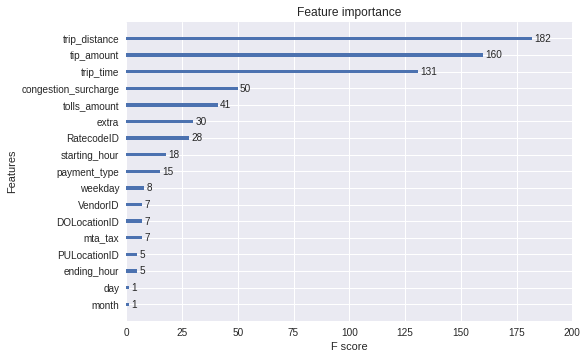

In [58]:

from xgboost import plot_importance
plot_importance(xgboost)